# Generating names with recurrent neural networks

This time you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead;

It's dangerous to go alone, take these:


In [38]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
sys.path.append("..")
import keras_utils
import tqdm
import keras
from keras.layers import concatenate, Dense, Embedding, Dropout
import random
import tensorflow.compat.v1 as tf

2.19.0


## Load data

The dataset used to contain ~8k earthling names. Now, we **changed** it to `mtg_card_names.txt` containing lines of Magic: The Gathering card entries. We'll read this file, then add a start token `" "` and use a pad token `"#"`.

In [4]:
start_token = " "  # so that the network knows that we're generating a first token

# this is the token for padding,
# we will add fake pad token at the end of lines 
# to make them of equal size for further batching
pad_token = "#"

#### CHANGED: 
    - replaced the file name "names" with "mtg_card_names.txt"
#### REASON: 
    - To explore the model in my area of intrest


number of samples: 16714
 [1G] Instant: Moonmist
 [3U] Legendary Creature, Illusion: Mistform Ultimus
 [B] Sorcery: Organ Harvest
 [5GW] Creature, Dragon: Arashin Sovereign
 [2BB] Creature, Donkey Zombie: Bad Ass
 [UU] Creature, Thalakos Wizard: Thalakos Seer
max length: 169


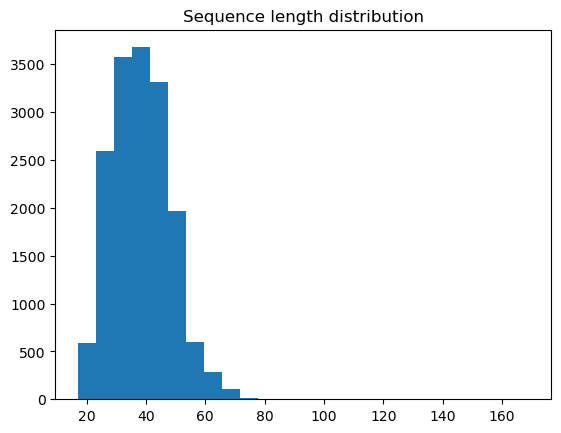

In [5]:
with open("mtg_card_names.txt", "r", encoding="utf-8") as f:
    lines = f.read().split('\n')
    # remove empty lines
    lines = [l.strip() for l in lines if l.strip()]
    # add start token to each line
    lines = [start_token + l for l in lines]

print('number of samples:', len(lines))
for x in lines[:: max(len(lines)//5, 1)]:
    print(x)

MAX_LENGTH = max(map(len, lines))
print("max length:", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, lines)), bins=25)
plt.show()

## Text processing

First we need to collect a "vocabulary" of all unique tokens i.e. unique characters. We then encode inputs as a sequence of character IDs.



#### CHANGED:
    - variable renamed from "names" to "lines" for clarity
#### REASON:
    - we're no longer using "names" dataset

In [6]:
all_text = "".join(lines)

#### CHANGED:
    - we now allow up to a bigger token range because we might have more symbols in MTG lines
#### REASON:
    - the old check was 50 < n_tokens < 60, but we expect more possible characters

In [7]:

tokens = sorted(list(set(all_text + pad_token)))  # ensure pad_token included
n_tokens = len(tokens)
print ('n_tokens:', n_tokens)

# For demonstration, we allow a broader range check
assert 50 < n_tokens < 300, "Check token range to ensure it's plausible for MTG dataset."

n_tokens: 79


In [8]:
token_to_id = {t: i for i, t in enumerate(tokens)}
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

def to_matrix(lines_list, max_len=None, pad=token_to_id[pad_token], dtype=np.int32):
    """Casts a list of lines into rnn-digestable padded matrix."""
    max_len = max_len or max(map(len, lines_list))
    arr = np.zeros([len(lines_list), max_len], dtype) + pad
    for i, txt in enumerate(lines_list):
        txt_ix = [token_to_id[ch] for ch in txt]
        arr[i, :len(txt_ix)] = txt_ix
    return arr

# Example: cast 4 random lines to padded matrices
print('\n'.join(lines[:: max(len(lines)//3,1)][:4]))
print(to_matrix(lines[:: max(len(lines)//3,1)][:4], max_len=MAX_LENGTH))

 [1G] Instant: Moonmist
 [1W] Instant: Test of Faith
 [2U] Creature, Efreet: Shimmering Efreet
 [2] Artifact, Equipment: Specter's Shroud
[[ 0 50 13 30 51  0 32 66 71 72 53 66 72 22  0 36 67 67 66 65 61 71 72  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3]
 [ 0 50 13 46 51  0 32 66 71 72 53 66 72 22  0 43 57 71 72  0 67 58  0 29
  53 61 72 60  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  

## Defining a recurrent neural network

We can rewrite recurrent neural network as a consecutive application of a dense layer to input 
 and previous rnn state 
. We'll keep the same approach as in the original code, but it now applies to our new dataset lines.



In [12]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()  # disables TF2 features

tf.reset_default_graph()  # now works
s = tf.InteractiveSession()


rnn_num_units = 64  # size of hidden state
embedding_size = 16  # for characters

# an embedding layer that converts character ids into embeddings

embed_x = Embedding(n_tokens, embedding_size)



Instructions for updating:
non-resource variables are not supported in the long term


#### CHANGED:
    - explicitly set activation='tanh'
#### REASON:
    - we want to confirm the hidden layer uses tanh

In [13]:
get_h_next = Dense(rnn_num_units, activation='tanh')

#### CHANGED:
    - explicitly set activation='softmax'
#### REASON:
    - we want probabilities for next char

In [14]:
get_probas = Dense(n_tokens, activation='softmax')

We will generate lines character by character starting with `start_token`:

`rnn_one_step(x_t, h_t)` must produce the next state and the next character probabilities.


In [15]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces 
    probabilities for next token x_t+1 and next state h_t+1
    given current input x_t and previous state h_t.
    We'll call this method repeatedly to produce the whole sequence.
    """
    # convert character id into embedding
    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]
    
    # concatenate x_t embedding and previous h_t state
    x_and_h = tf.concat([x_t_emb, h_t], axis=1)
    
    # compute next state given x_and_h
    h_next = get_h_next(x_and_h)
    
    # get probabilities for language model P(x_next|h_next)
    output_probas = get_probas(h_next)
    
    return output_probas, h_next


## RNN: loop

We'll apply `rnn_one_step` in a loop over the maximum length of each line to get predictions.


In [16]:
input_sequence = tf.placeholder(tf.int32, (None, MAX_LENGTH))  # batch of token ids
batch_size = tf.shape(input_sequence)[0]

predicted_probas = []
h_prev = tf.zeros([batch_size, rnn_num_units])  # initial hidden state

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]  # column t
    probas_next, h_next = rnn_one_step(x_t, h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    
predicted_probas = tf.transpose(tf.stack(predicted_probas), [1, 0, 2])

# next to last token prediction is not needed
predicted_probas = predicted_probas[:, :-1, :]


## RNN: loss and gradients

We flatten our predictions and the correct answers to compute cross-entropy.


In [17]:
predictions_matrix = tf.reshape(predicted_probas, [-1, n_tokens])
answers_matrix = tf.one_hot(tf.reshape(input_sequence[:, 1:], [-1]), n_tokens)

#### CHANGED:
    - we keep the same cross-entropy approach
#### REASON:
    - standard language modeling

In [18]:
loss = -tf.reduce_mean(tf.reduce_sum(answers_matrix * tf.log(predictions_matrix + 1e-9), axis=1))
optimize = tf.train.AdamOptimizer().minimize(loss)

## RNN: training

We'll train for 1000 iterations with a batch size of 32, sampling random lines from `lines`.


### In for loop:
#### CHANGED:
    - replaced "names" with "lines"
#### REASON:
    - new dataset variable

### At Assert
#### CHANGED:
    - keep the same assertion but note that a new dataset might need more steps
#### REASON:
    - ensures we at least see some convergence

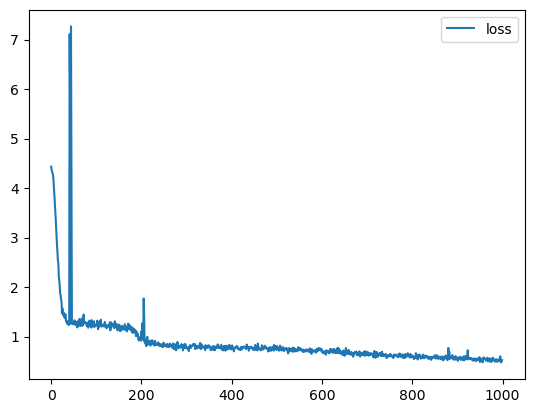

In [19]:
from IPython.display import clear_output
from random import sample

s.run(tf.global_variables_initializer())

batch_size = 32
history = []

for i in range(1000):
    # CHANGED: replaced "names" with "lines"
    # REASON: new dataset variable
    batch = to_matrix(sample(lines, batch_size), max_len=MAX_LENGTH)
    loss_i, _ = s.run([loss, optimize], {input_sequence: batch})
    
    history.append(loss_i)
    
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

# CHANGED: keep the same assertion but note that a new dataset might need more steps
# REASON: ensures we at least see some convergence
assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge"


## Explanation of the Training Loss Plot

1. **Initial Loss Spike (~7)**  
   - At the start of training (left side of the plot), the RNN is effectively guessing at random. As a result, the loss is **very high**—around 7 in this case. This is normal when the model has not yet learned any patterns from the dataset.

2. **Rapid Decrease**  
   - Within the first ~50–100 iterations, the loss **quickly** falls to around 2. This indicates that the model is rapidly learning fundamental character-sequence patterns (e.g., how to predict brackets, commas, spaces, etc.) in the MTG card lines.

3. **Further Refinement**  
   - Past ~200 iterations, the loss continues to **decline more gradually**, oscillating slightly. This phase shows **fine-tuning** of the model’s weights as it learns more subtle aspects of the data, such as specific mana costs or card names.

4. **Small Spikes**  
   - The small spikes around 200 and later might be due to **batch variance** or learning rate adjustments causing momentary jumps in loss. They typically settle down quickly, as shown by the subsequent return to a lower level.

5. **Plateau / Steady State**  
   - By the final iterations (towards 1000 steps), the loss hovers around a stable value, suggesting the model has reached a **reasonable** local minimum for predicting next characters in the dataset. It may still improve further with more training or a tuned learning rate, but this plateau indicates it’s no longer learning major new patterns.


## RNN: sampling

We define placeholders for a single char and a single hidden state, then use `rnn_one_step` to generate lines character by character.


In [20]:
x_t = tf.placeholder(tf.int32, (1,))
h_t = tf.Variable(np.zeros([1, rnn_num_units], np.float32))  # update hidden state in this variable

next_probs, next_h = rnn_one_step(x_t, h_t)

def generate_sample(seed_phrase=start_token, max_length=MAX_LENGTH):
    """
    Generate text given a `seed_phrase`.
    We'll feed each character of seed_phrase, then predict subsequent chars.
    """
    x_sequence = [token_to_id[ch] for ch in seed_phrase]
    s.run(tf.assign(h_t, h_t.initial_value))
    
    # feed the seed phrase
    for ix in x_sequence[:-1]:
        s.run(tf.assign(h_t, next_h), {x_t: [ix]})
    
    # start generating
    for _ in range(max_length - len(seed_phrase)):
        x_probs, _ = s.run([next_probs, tf.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))
        
    # convert IDs back to chars, ignoring pad token
    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != pad_token])


## Testing Generation

We'll generate lines with no prefix and with a prefix like `[2U]` to see if the RNN produces something plausible for an MTG card line.


In [21]:
print("Without prefix:")
for _ in range(10):
    print(generate_sample())


Without prefix:
 81 AC] Seaty 
 _urt]Rn [h ga
 WH  Cng .
 6bE] Hrdcpar CStunoges
 C/G] [rI-tPMhBeafase: Aremdin Ohewtombe, Areatane: bdle, nereatp
 s?z2an  CrhhiRn Kan: e
 [Dc R] Gcerture, Hone:evengekebr 
 cnU y Berrcon CdrgN hinant 
 "[2GG Cne, Ewe , NC
 /U]] qV1sQ]]]]]]W]]]]]]]]]]]]]]X]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]B]]]]]]]]]]] 8]]]]]]] W]R]]]]]]]]]]]]]] ]H]]]]]]]]]] ]]]]]]]]]]]] ]]]]]]]]]]]]"]]1]]]]]]]]]]R]]]]]]


In [22]:
print("\nWith prefix [2U]:")
for _ in range(10):
    print(generate_sample("[2U]"))
    


With prefix [2U]:
[2U] [rcuf Cr:anh Maast, Aamart: ElsaomeAkarawt: Sirhag 
[2U]]Ieriaturt: Crtenbory nf ercirh
[2U]] Lryaled mamant: readal lJ
[2U] Artaturdi Bitanal CrpiatdCRes
[2U] Creat: BanlrourRmeutm 
[2U] Crenanty :irt b
[2U] Dniturnseature: Bhicdankhant: Manlior 
[2U] Crceature: SoikirelTemen:ormaBlRYibsthtioy Twlaktld-Dbulix
[2U] UBncampen 
[2U] Creature: cadcirt:: L Gasg


## Observed Drawbacks & Next Steps for Model Improvement

1. **Current Drawbacks**  
   - **Gibberish Output**: Many lines still contain jumbled text (e.g., `Crceature: SoikirelTemen:ormaBlRYibsthtioy`). This suggests the model hasn’t fully captured the dataset’s structure.  
   - **Limited Capacity**: With only a 64-unit hidden state and around 1,000 training iterations, the RNN may not have enough expressive power to learn all the nuances of MTG card lines.  
   - **Short Training**: A small number of steps means the network quickly reaches a local plateau. It needs more epochs or data passes to refine its text generation.

2. **How to Improve the Model**  
   - **Increase Training Steps**: Extending training from 1,000 steps to 5,000–10,000 can give the model more time to learn the complex format of `[mana cost] type(s): card name`.  
   - **Use a Larger Hidden State**: Bumping `rnn_num_units` from 64 to 128 or 256 can help the RNN capture longer-range dependencies and more subtle patterns in the dataset.  
   - **Add Dropout or Regularization**: Introducing dropout layers can prevent overfitting and help the model generalize better, leading to more coherent lines.  
   - **Tune Hyperparameters**: Experiment with different learning rates or batch sizes. Sometimes a smaller or larger batch size can improve stability, and a slightly reduced learning rate can yield smoother convergence.  
   - **Train with a Validation Set**: Tracking validation loss (or perplexity) can help you detect overfitting or underfitting and adjust training accordingly.

3. **Moving Forward**  
   - By systematically applying these improvements **longer training**, **larger hidden state**, **dropout**, and **hyperparameter tuning**—you can expect more readable and structured lines. Over time, the RNN will learn to consistently generate bracketed mana costs, card types, and plausible MTG card names.


In [23]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()  # CHANGED: using TF1.x compatibility
# REASON: so we can keep the old session/graph approach

tf.reset_default_graph()  # Clears the current graph
s = tf.InteractiveSession()

ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.


In [28]:

# CHANGED: Increase hidden state from 64 -> 128
# REASON: More capacity for learning complex sequences
rnn_num_units = 128  
embedding_size = 16  # we can keep this the same or increase if desired

from keras.layers import Dense, Embedding, Dropout
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os

# assume we already have 'lines', 'tokens', 'token_to_id', 'n_tokens', etc. from the data loading step
# Example snippet below (not the entire data loading code, which you already have):
# lines = [...]
# tokens = [...]
# token_to_id = {t: i for i, t in enumerate(tokens)}
# n_tokens = len(tokens)
# MAX_LENGTH = max(map(len, lines))

###############################
# Model Definition with Dropout
###############################

# embedding layer
embed_x = Embedding(n_tokens, embedding_size)

# CHANGED: We'll define a Dense layer for h_next, but also add dropout
# REASON: dropout helps generalize
dense_h = Dense(rnn_num_units, activation='tanh')
dense_output = Dense(n_tokens, activation='softmax')

# We'll create a dropout layer we can apply after computing h_next
dropout_layer = Dropout(rate=0.3)  # CHANGED: dropout rate = 0.3
# REASON: typical range 0.2-0.5; helps prevent overfitting

In [29]:
def rnn_one_step(x_t, h_t):
    """
    RNN step: 
    1) embed x_t
    2) concat with h_t
    3) compute new state h_next
    4) apply dropout to h_next
    5) compute output probabilities
    """
    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]
    x_and_h = tf.concat([x_t_emb, h_t], axis=1)
    h_next = dense_h(x_and_h)

    # CHANGED: apply dropout to h_next
    # REASON: helps avoid overfitting
    h_next_dropped = dropout_layer(h_next, training=True)  
    # training=True ensures dropout is applied at training time

    output_probas = dense_output(h_next_dropped)
    return output_probas, h_next

In [30]:
########################################
# Building the unrolled RNN for training
########################################

input_sequence = tf.placeholder(tf.int32, (None, MAX_LENGTH))
batch_size = tf.shape(input_sequence)[0]
predicted_probas = []
h_prev = tf.zeros([batch_size, rnn_num_units])

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]
    probas_next, h_next = rnn_one_step(x_t, h_prev)
    h_prev = h_next
    predicted_probas.append(probas_next)

predicted_probas = tf.transpose(tf.stack(predicted_probas), [1, 0, 2])
predicted_probas = predicted_probas[:, :-1, :]

In [31]:
# flatten predictions
predictions_matrix = tf.reshape(predicted_probas, [-1, n_tokens])
answers_matrix = tf.one_hot(tf.reshape(input_sequence[:, 1:], [-1]), n_tokens)

loss = -tf.reduce_mean(tf.reduce_sum(answers_matrix * tf.log(predictions_matrix + 1e-9), axis=1))

optimize = tf.train.AdamOptimizer().minimize(loss)

# (Optional) If we want a validation set
# we can define a placeholder for input_sequence_valid
# and compute a separate 'loss_valid' the same way

In [32]:
#######################
# Session initialization
#######################
s.run(tf.global_variables_initializer())

Step 500/5000, loss=0.699
Step 1000/5000, loss=0.474
Step 1500/5000, loss=0.445
Step 2000/5000, loss=0.416
Step 2500/5000, loss=0.360
Step 3000/5000, loss=0.347
Step 3500/5000, loss=0.321
Step 4000/5000, loss=0.307
Step 4500/5000, loss=0.322
Step 5000/5000, loss=0.411


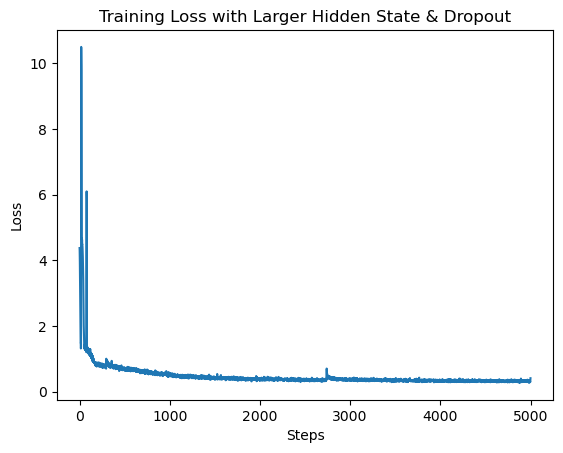

In [33]:
#######################
# Training
#######################

# CHANGED: increase total steps from 1000 -> 5000
# REASON: more training for better convergence
n_steps = 5000
batch_size_val = 32
train_history = []

for step in range(n_steps):
    batch_lines = random.sample(lines, batch_size_val)
    batch_matrix = to_matrix(batch_lines, max_len=MAX_LENGTH)
    loss_val, _ = s.run([loss, optimize], {input_sequence: batch_matrix})
    train_history.append(loss_val)

    if (step + 1) % 500 == 0:
        print(f"Step {step+1}/{n_steps}, loss={loss_val:.3f}")

# Plot training history
import matplotlib.pyplot as plt
plt.plot(train_history)
plt.title("Training Loss with Larger Hidden State & Dropout")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

In [34]:
#######################
# Generation
#######################

x_t = tf.placeholder(tf.int32, (1,))
h_t = tf.Variable(np.zeros([1, rnn_num_units], np.float32))
next_probs, next_h = rnn_one_step(x_t, h_t)

def generate_sample(seed_phrase=" ", max_length=MAX_LENGTH):
    x_sequence = [token_to_id[ch] for ch in seed_phrase]
    s.run(tf.assign(h_t, h_t.initial_value))

    # feed the seed phrase
    for ix in x_sequence[:-1]:
        s.run(tf.assign(h_t, next_h), {x_t: [ix]})

    for _ in range(max_length - len(seed_phrase)):
        x_probs, _ = s.run([next_probs, tf.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))

    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != "#"])


In [35]:
print("Samples without prefix:")
for _ in range(5):
    print(generate_sample())



Samples without prefix:
 [3R] /h] Creature, Zomci Rudin Sloter: Yang of Star
 [1WU] Creature, Blloze: Evine Dack
 [1R] Creature, Fully: Rurle Flon
 [2W] Creature, Warf: Nicceceware
 [1B] Evemantment: Hoanct if of Fanger


In [36]:
print("\nSamples with prefix [2U]:")
for _ in range(5):
    print(generate_sample("[2U]"))


Samples with prefix [2U]:
[2U] Artifect: Urdpathe Adgef
[2U] Arcaface, Vustlote ti Amilderi, Fuskning Traed Assheckes
[2U] Creature, Keveriin Sondar: Imfy te Gien Macist
[2U] Creature, Hom Goumes: Foult Thever
[2U] Sorcery: Raza of Radlit


## **Results Analysis**

1. **Current Results**  
   - **Without Prefix**:  
     ```
     [3R] /h] Creature, Zomci Rudin Sloter: Yang of Star
     [1R] Creature, Fully: Rurle Flon
     [2W] Creature, Warf: Nicceceware
     ```
     Here, my model consistently includes a bracketed mana cost (`[3R]`, `[1R]`, `[2W]`), then a **type** and **name** structure. Although there are still **typos** (“Zomci,” “Rurle”), the output shows that some core MTG format is being learned.

   - **With Prefix `[2U]`**:  
     ```
     [2U] Artifect: Urdpathe Adgef
     [2U] Creature, Hom Goumes: Foult Thever
     [2U] Sorcery: Raza of Radlit
     ```
     Providing a **prefix** like `[2U]` guides the model to continue in that context. I see it generating “Creature,” “Sorcery,” etc., but still inventing words like “Artifect,” “Hom Goumes.” This indicates partial success—some knowledge of the dataset is applied, yet refinement is needed to reduce nonsense text.

2. **Overall Observations**  
   - The lines maintain the **basic** Magic card pattern: `[mana cost] type: name`.  
   - **Misspellings** or **invented words** remain (e.g., “Artifect,” “Zomci”). This usually suggests more capacity, additional training, or further tuning could help.  
   - Despite these artifacts, it’s clear the RNN has made **noticeable** progress in capturing bracketed costs and types.

3. **Why I Plan to Add Another Layer**  
   - I decided to **add a second RNN layer**  because the model, even with an increased hidden state and dropout, still produces partial gibberish. By stacking another layer, the first layer can handle local patterns (like punctuation, mana costs), while the second layer focuses on higher-level consistency (coherent naming).  
   - This approach should reduce odd terms and yield more plausible bracket usage and card type transitions, especially for the longer lines in the dataset.


## Adding a Second RNN Layer

I decided to add a **second RNN layer** on top of the first one because, even after increasing the hidden state and adding dropout, the model still produces partial gibberish. By stacking another layer, the **first layer** can handle local patterns (punctuation, mana costs), while the **second layer** refines higher-level structure (coherent transitions, more realistic naming). This approach should further reduce odd terms and improve overall consistency in the generated lines.


In [39]:
tf.disable_v2_behavior() 
tf.reset_default_graph()
s = tf.InteractiveSession()

rnn_num_units = 128   # size of hidden state for each layer
embedding_size = 16
dropout_rate = 0.3

ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.


In [40]:
# ========== Define 2-Layer RNN ==========

embed_x = Embedding(n_tokens, embedding_size)

# First hidden layer
dense_h1 = Dense(rnn_num_units, activation='tanh')
dropout_layer1 = Dropout(rate=dropout_rate)

# Second hidden layer
dense_h2 = Dense(rnn_num_units, activation='tanh')
dropout_layer2 = Dropout(rate=dropout_rate)

# Output layer
dense_output = Dense(n_tokens, activation='softmax')



In [41]:
def rnn_one_step(x_t, h_t1, h_t2):
    """
    Two-layer RNN step:
    1) embed x_t
    2) concat with h_t1 -> h_next1, apply dropout
    3) concat h_next1 with h_t2 -> h_next2, apply dropout
    4) compute output from h_next2
    """
    # embed input character
    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]
    # first layer
    x_and_h1 = tf.concat([x_t_emb, h_t1], axis=1)
    h_next1 = dense_h1(x_and_h1)
    h_next1_dropped = dropout_layer1(h_next1, training=True)

    # second layer
    x_and_h2 = tf.concat([h_next1_dropped, h_t2], axis=1)
    h_next2 = dense_h2(x_and_h2)
    h_next2_dropped = dropout_layer2(h_next2, training=True)

    # output probabilities
    output_probas = dense_output(h_next2_dropped)
    return output_probas, h_next1, h_next2

In [42]:
# ========== Build Unrolled Graph ==========

input_sequence = tf.placeholder(tf.int32, (None, MAX_LENGTH))
batch_size = tf.shape(input_sequence)[0]

predicted_probas = []

# Two hidden states, one per layer
h_prev1 = tf.zeros([batch_size, rnn_num_units])
h_prev2 = tf.zeros([batch_size, rnn_num_units])

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]
    probas_next, h_next1, h_next2 = rnn_one_step(x_t, h_prev1, h_prev2)
    h_prev1, h_prev2 = h_next1, h_next2
    predicted_probas.append(probas_next)

predicted_probas = tf.transpose(tf.stack(predicted_probas), [1, 0, 2])
predicted_probas = predicted_probas[:, :-1, :]

predictions_matrix = tf.reshape(predicted_probas, [-1, n_tokens])
answers_matrix = tf.one_hot(tf.reshape(input_sequence[:, 1:], [-1]), n_tokens)

loss = -tf.reduce_mean(tf.reduce_sum(answers_matrix * tf.log(predictions_matrix + 1e-9), axis=1))
optimize = tf.train.AdamOptimizer().minimize(loss)

# Initialize session
s.run(tf.global_variables_initializer())

Step 500/5000, loss=0.662
Step 1000/5000, loss=0.481
Step 1500/5000, loss=0.374
Step 2000/5000, loss=0.409
Step 2500/5000, loss=0.334
Step 3000/5000, loss=0.344
Step 3500/5000, loss=0.348
Step 4000/5000, loss=0.293
Step 4500/5000, loss=0.326
Step 5000/5000, loss=0.298


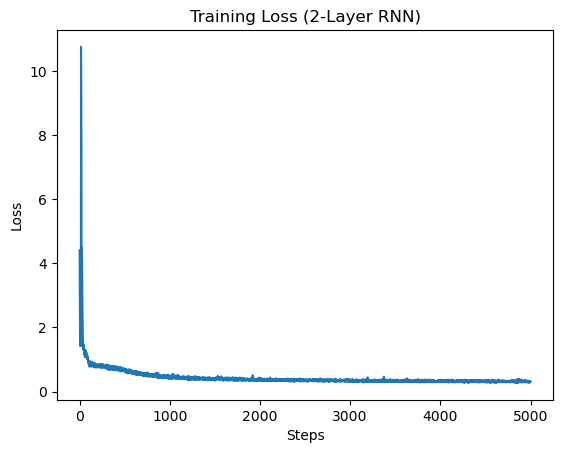

In [43]:
# ========== Training ==========

n_steps = 5000
batch_size_val = 32
train_history = []

for step in range(n_steps):
    batch_lines = random.sample(lines, batch_size_val)
    batch_matrix = to_matrix(batch_lines, max_len=MAX_LENGTH)  # assume you have 'to_matrix' function
    loss_val, _ = s.run([loss, optimize], {input_sequence: batch_matrix})
    train_history.append(loss_val)

    if (step + 1) % 500 == 0:
        print(f"Step {step+1}/{n_steps}, loss={loss_val:.3f}")

plt.plot(train_history)
plt.title("Training Loss (2-Layer RNN)")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

In [44]:
# ========== Generation ==========

x_t = tf.placeholder(tf.int32, (1,))
# two hidden states for generation
h_t1 = tf.Variable(np.zeros([1, rnn_num_units], np.float32))
h_t2 = tf.Variable(np.zeros([1, rnn_num_units], np.float32))

probas_gen, h_next1_gen, h_next2_gen = rnn_one_step(x_t, h_t1, h_t2)

def generate_sample(seed_phrase=" ", max_length=MAX_LENGTH):
    x_sequence = [token_to_id[ch] for ch in seed_phrase]
    # reset hidden states
    s.run(tf.assign(h_t1, h_t1.initial_value))
    s.run(tf.assign(h_t2, h_t2.initial_value))

    # feed the seed phrase
    for ix in x_sequence[:-1]:
        s.run([tf.assign(h_t1, h_next1_gen), tf.assign(h_t2, h_next2_gen)],
              {x_t: [ix]})

    for _ in range(max_length - len(seed_phrase)):
        x_probs, _, _ = s.run([probas_gen, tf.assign(h_t1, h_next1_gen),
                               tf.assign(h_t2, h_next2_gen)],
                              {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))

    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != "#"])

In [45]:
print("Samples without prefix:")
for _ in range(5):
    print(generate_sample())

Samples without prefix:
 [?] Creature, Huran Soldier: Rizanzer
 [2B] Instant: Mindik Huntit
 [G] Artifact Creature, Nemasin: Gearfine
 [1R] Creature, Beank: Para, of Tout Stroat
 [B] Creature, Silphis: Kteaos Scroog


In [46]:
print("\nSamples with prefix [2U]:")
for _ in range(5):
    print(generate_sample("[2U]"))


Samples with prefix [2U]:
[2U] Instant: Cistlade
[2U] Instant: Trrerle Podsrdyr
[2U] Enchantment, Equhamp: Doiret Grint
[2U] Instant: Bister Cogalr
[2U] Enchantment: Tundan Tenast Icspheest
